In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dotenv
import os
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
import os
from joblib import dump, load
import scipy.stats as stats
%matplotlib inline

In [3]:
print(dotenv.load_dotenv())

True


In [4]:
print(os.getenv('data_path'))

/home/ziad/MachineLearning/Projects/Car-travels/Data/car_travels.csv


In [5]:
data = pd.read_csv(os.getenv('data_path'))
data.head()

,User ID,User Name,Driver Name,Car Condition,Weather,Traffic Condition,key,fare_amount,pickup_datetime,pickup_longitude,...,month,weekday,year,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist,distance,bearing
0,KHVrEVlD,Kimberly Adams,Amy Butler,Very Good,windy,Congested Traffic,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-1.288826,...,6,0,2009,20.265840,55.176046,14.342611,34.543548,27.572573,1.030764,-2.918897
1,lPxIuEri,Justin Tapia,Hannah Zimmerman,Excellent,cloudy,Flow Traffic,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-1.291824,...,1,1,2010,44.667679,31.832358,23.130775,15.125872,8.755732,8.450134,-0.375217
2,gsVN8JLS,Elizabeth Lopez,Amanda Jackson,Bad,stormy,Congested Traffic,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-1.291242,...,8,3,2011,43.597686,33.712082,19.865289,17.722624,9.847344,1.389525,2.599961
3,9I7kWFgd,Steven Wilson,Amy Horn,Very Good,stormy,Flow Traffic,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-1.291319,...,4,5,2012,42.642965,32.556289,21.063132,15.738963,7.703421,2.799270,0.133905
4,8QN5ZaGN,Alexander Andrews,Cassandra Larson,Bad,stormy,Congested Traffic,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-1.290987,...,3,1,2010,43.329953,39.406828,15.219339,23.732406,15.600745,1.999157,-0.502703


In [6]:
data.columns

Index(['User ID', 'User Name', 'Driver Name', 'Car Condition', 'Weather',
       'Traffic Condition', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist',
       'nyc_dist', 'distance', 'bearing'],
      dtype='object')

## Useful Functions

In [7]:
def set_ticks_(axs, i):
    """
    Set the ticks for the plot.
    """
    yticks = axs[i].get_yticks()
    scaled_yticks = sqrt_scale(yticks)
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels([f'{val:.1f}' for val in scaled_yticks])

In [8]:
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05) # modified this because most of the data is only from 0 to 20 in fare amount
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)][column]


In [9]:
def drop_outliers_df(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.05) # modified this because most of the data is only from 0 to 20 in fare amount
        Q3 = df[column].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df


In [10]:
def sqrt_scale(y):
    return np.sqrt(y)

In [11]:
def set_title_(axes, i, column):
    axes[i].set_title(column)

In [12]:
def set_labels_(axes, i, label_x, label_y):
    axes[i].set_xlabel(label_x)
    axes[i].set_ylabel(label_y)

In [13]:
def Spearman(feature1, feature2):
    print(feature1)
    # Calculate Spearman correlation coefficient
    spearman_corr, p_value = stats.spearmanr(data_num[feature1], data_num[feature2])

    print(f"Spearman correlation coefficient: {spearman_corr} for feature {feature1} for P-value: {p_value}")
    if p_value <= 0.1 and np.abs(spearman_corr) > 0.15:
        return True
    else:
        return False

In [14]:
def is_significant_anova(data, numerical_col, categorical_col,dof1, alpha=0.15):
    """
    Perform ANOVA to determine if there is a significant correlation
    between a numerical variable and a categorical variable.

    Parameters:
    - data: DataFrame containing the data.
    - numerical_col: Name of the numerical column.
    - categorical_col: Name of the categorical column.
    - alpha: Significance level (default is 0.05).

    Returns:
    - True if the p-value is less than or equal to alpha, indicating significant correlation.
    - False otherwise.
    """
    dof2 = 482997 - dof1  + 1 # number of observations - number of groups
    critical_value = stats.f.ppf(1 - alpha, dof1, dof2)
    # Perform ANOVA

    formula = f'{numerical_col} ~ C({categorical_col})'
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Extract the p-value
    p_value = anova_table['PR(>F)'][0]
    # Extract components
    f_value = anova_table['F'][0]
    print(f"For feature {categorical_col} the p value is {p_value}, Critical is {critical_value} and F-statistic {f_value}")
    
    # Return True if the p-value is less than or equal to alpha
    return p_value <= alpha and f_value > critical_value

## EDA

In [15]:
data.isna().sum().sort_values()

User ID              0
User Name            0
Driver Name          0
Car Condition        0
Weather              0
Traffic Condition    0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
passenger_count      0
day                  0
hour                 0
weekday              0
month                0
year                 0
dropoff_longitude    5
dropoff_latitude     5
jfk_dist             5
ewr_dist             5
lga_dist             5
sol_dist             5
nyc_dist             5
distance             5
bearing              5
dtype: int64

In [16]:
data.drop(['User ID','key'],axis= 1, inplace= True) # features already extracted from them.
data.columns

Index(['User Name', 'Driver Name', 'Car Condition', 'Weather',
       'Traffic Condition', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist',
       'nyc_dist', 'distance', 'bearing'],
      dtype='object')

In [17]:
print(data['Car Condition'].unique())

['Very Good' 'Excellent' 'Bad' 'Good']


In [18]:
condition_map = {
    'Excellent': 3,
    'Very Good': 2,
    'Good': 1,
    'Bad': 0
}
data['Car_Condition_coded'] = data['Car Condition'].map(condition_map)
data['Car_Condition_coded']

0         2
1         3
2         0
3         2
4         0
         ..
499995    0
499996    2
499997    0
499998    1
499999    2
Name: Car_Condition_coded, Length: 500000, dtype: int64

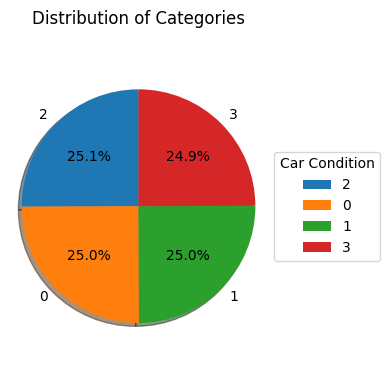

In [19]:
car_value_counts = data['Car_Condition_coded'].value_counts()

# Create a pie chart
plt.figure(figsize=(4,4))
plt.pie(car_value_counts.values, labels=car_value_counts.index, autopct='%1.1f%%', startangle=90,shadow=True)
plt.title('Distribution of Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add a legend
plt.legend(title="Car Condition", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

<Axes: xlabel='fare_amount', ylabel='Weather'>

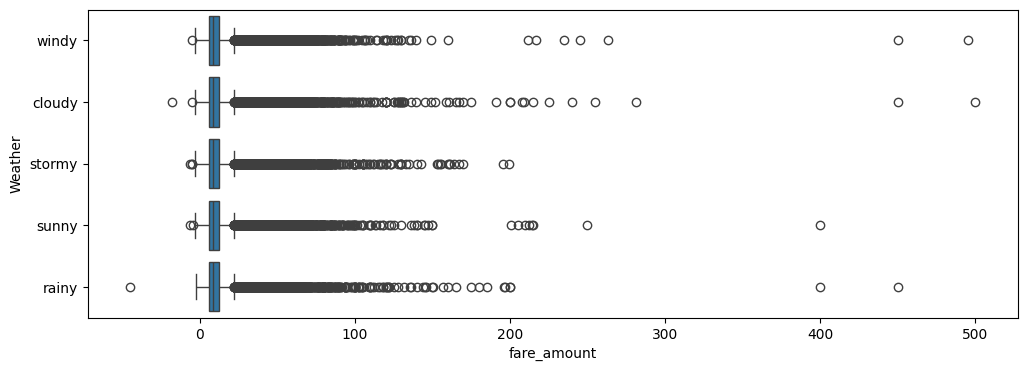

In [20]:
plt.figure(figsize=(12,4))
sns.boxplot(x='fare_amount', data= data, y='Weather')

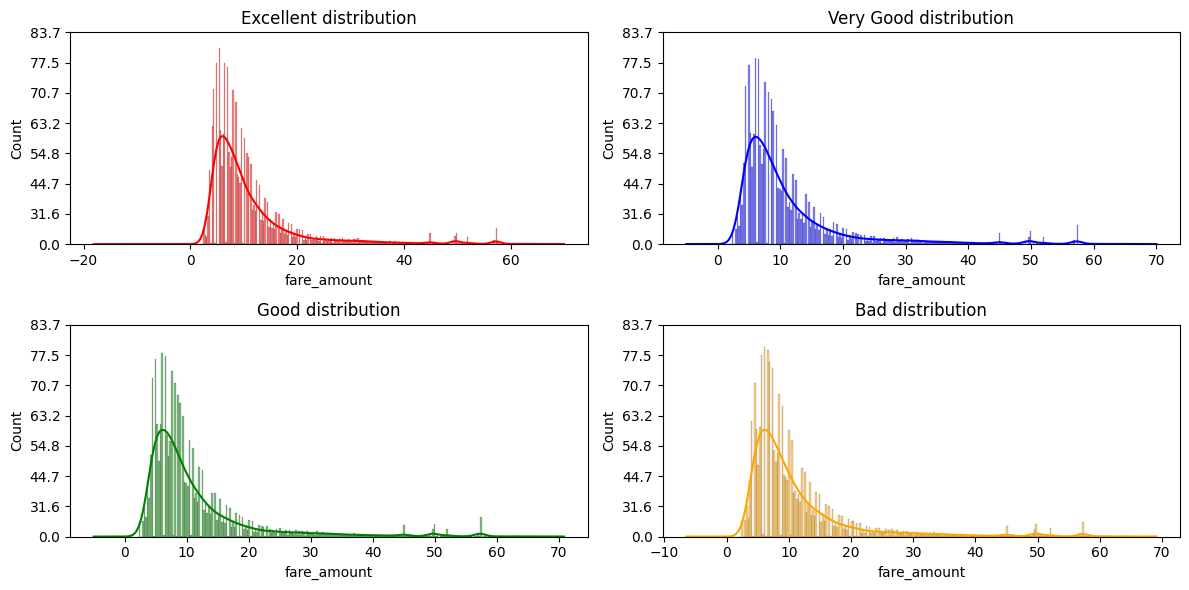

In [21]:
fig, ax = plt.subplots(nrows= 2, ncols= 2, figsize=(12, 6))
ax = ax.flatten()
colors =['red','blue','green','orange']
titles = ['Excellent distribution', 'Very Good distribution', 'Good distribution', 'Bad distribution']

for i, title in enumerate(titles):
    sns.histplot(drop_outliers_iqr(data[data['Car_Condition_coded'] == i],'fare_amount'),ax= ax[i],kde= True,color= colors[i])
    set_ticks_(i=i, axs= ax)
    set_title_(i=i, axes= ax, column= title)

plt.tight_layout()
plt.show()

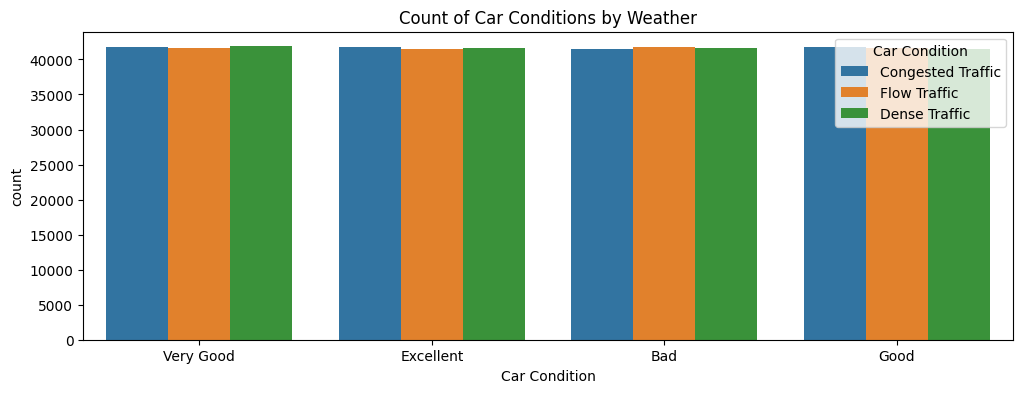

In [22]:
plt.figure(figsize=(12,4))
sns.countplot(
    data= data,
    x= 'Car Condition',
    hue='Traffic Condition'
)

plt.title('Count of Car Conditions by Weather')
plt.legend(title='Car Condition', loc='upper right')


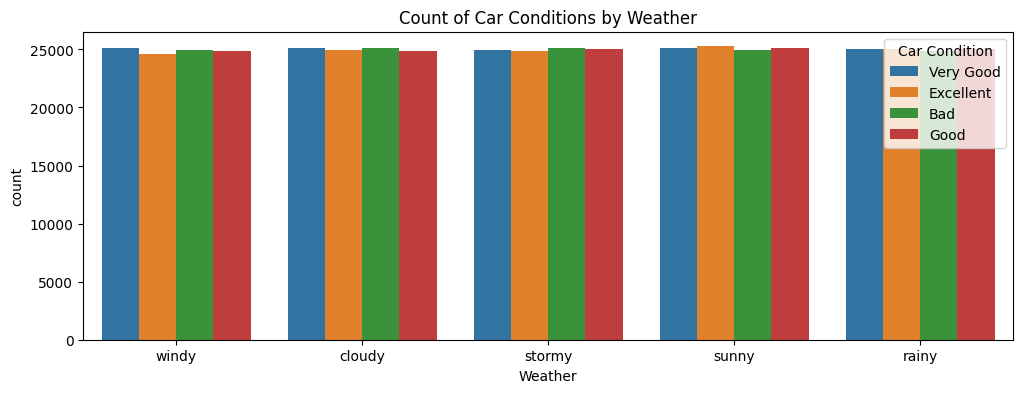

In [23]:
plt.figure(figsize=(12,4))
sns.countplot(
    data= data,
    x= 'Weather',
    hue='Car Condition'
)

plt.title('Count of Car Conditions by Weather')
plt.legend(title='Car Condition', loc='upper right')


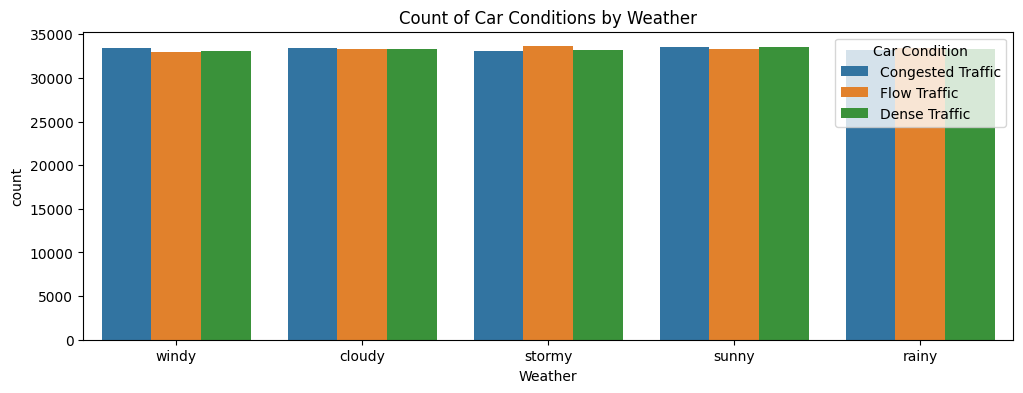

In [24]:
plt.figure(figsize=(12,4))
sns.countplot(
    data= data,
    x= 'Weather',
    hue='Traffic Condition'
)

plt.title('Count of Car Conditions by Weather')
plt.legend(title='Car Condition', loc='upper right')


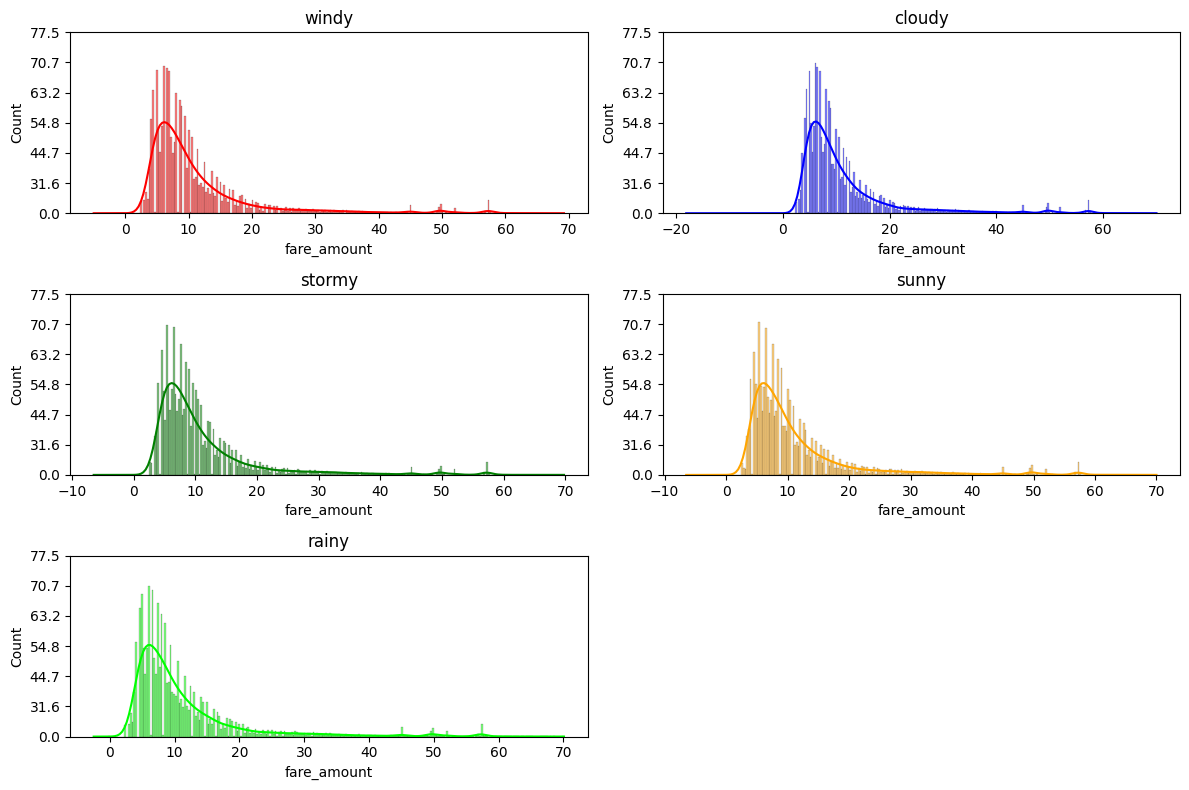

In [25]:
fig, axs = plt.subplots(nrows= 3, ncols= 2, figsize=(12, 8))
axs = axs.flatten()
colors = ['red','blue','green','orange','lime']
weather_cond = data['Weather'].unique()
for i, ax in enumerate(axs):
    if i < 5:
        sns.histplot(drop_outliers_iqr(data[data['Weather'] == weather_cond[i]],'fare_amount'),ax= axs[i],kde= True,color= colors[i])
        set_ticks_(i=i, axs= axs)
        set_title_(i=i, axes= axs, column= weather_cond[i])
    else:
        ax.axis('off')  # Turn off the unused subplot
    
plt.tight_layout()
plt.show()

right skewed -> take the sqrt

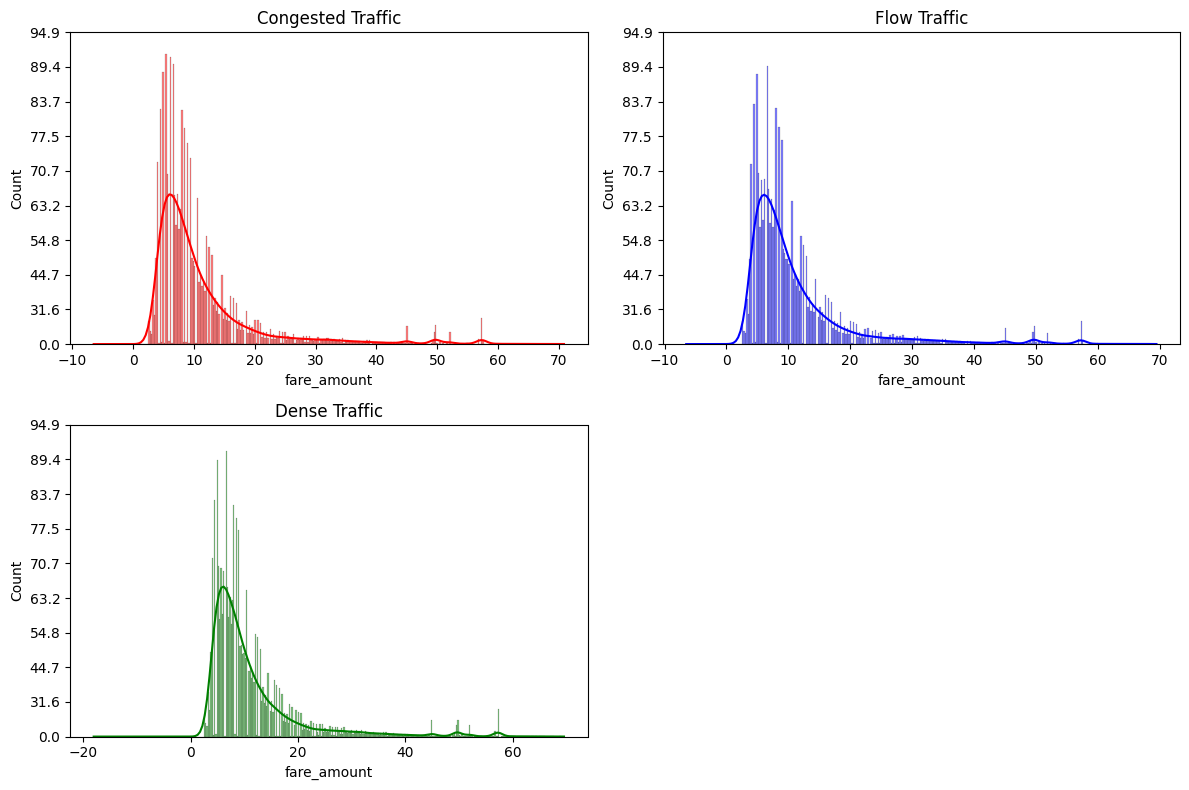

In [26]:
fig, axs = plt.subplots(nrows= 2, ncols= 2, figsize=(12, 8))
axs = axs.flatten()
colors = ['red','blue','green']
traffic_cond = data['Traffic Condition'].unique()
for i, ax in enumerate(axs):
    if i < 3:
        sns.histplot(drop_outliers_iqr(data[data['Traffic Condition'] == traffic_cond[i]],'fare_amount'),ax= axs[i],kde= True,color= colors[i])
        set_ticks_(i=i, axs= axs)
        set_title_(i=i, axes= axs, column= traffic_cond[i])
    else:
        ax.axis('off')  # Turn off the unused subplot
    
plt.tight_layout()
plt.show()

Dense traffic has more negative values than the rest in dense traffic which indicates cutomer's anger or so.

In [27]:
data.columns

Index(['User Name', 'Driver Name', 'Car Condition', 'Weather',
       'Traffic Condition', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist',
       'nyc_dist', 'distance', 'bearing', 'Car_Condition_coded'],
      dtype='object')

### Top Drivers

In [28]:
top_drivers = data.groupby('Driver Name').agg(
    {
        'User Name': 'count',
        'fare_amount': 'mean'
    }
).reset_index().rename(columns={'User Name': 'count',
                            'fare_amount': 'mean of rides'}
                       )
top_drivers

,Driver Name,count,mean of rides
0,Aaron Acosta,1,4.900000
1,Aaron Adams,6,9.283333
2,Aaron Aguilar,1,8.500000
3,Aaron Aguirre,1,4.100000
4,Aaron Allen,6,14.216667
...,...,...,...
221695,Zoe Wilkinson,1,5.500000
221696,Zoe Wilson,1,6.000000
221697,Zoe Woodard,1,12.900000
221698,Zoe Wright,1,9.700000


In [29]:
top_drivers_trips = top_drivers.nlargest(10,'count')
top_drivers_fare = top_drivers.nlargest(10,'mean of rides')

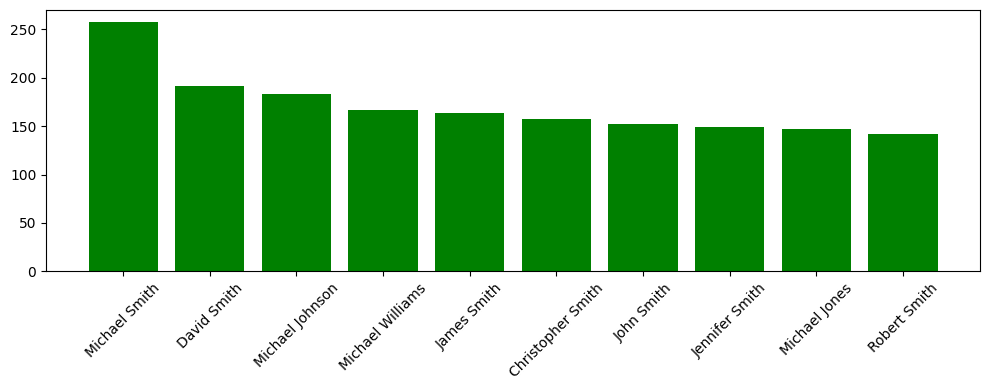

In [30]:
plt.figure(figsize=(10,4))
plt.bar(top_drivers_trips['Driver Name'], top_drivers_trips['count'], color='green')
plt.xticks(rotation= 45)
plt.tight_layout()

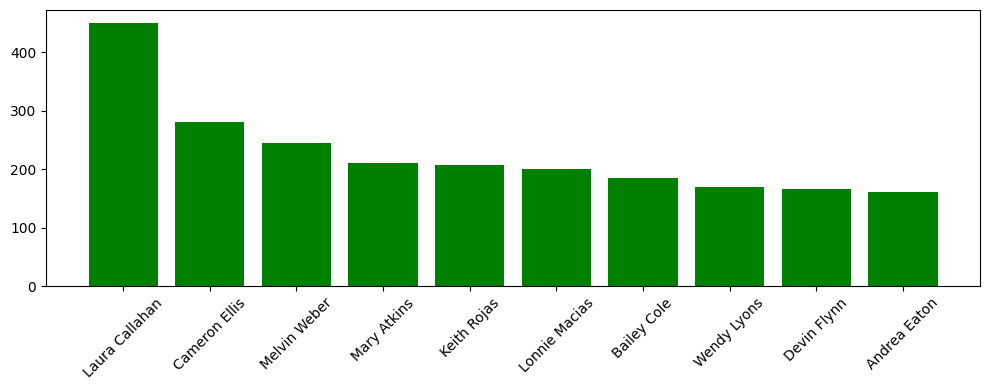

In [31]:
plt.figure(figsize=(10,4))
plt.bar(top_drivers_fare['Driver Name'], top_drivers_fare['mean of rides'], color='green')
plt.xticks(rotation= 45)
plt.tight_layout()

None of top 10 drivers rides are in in top 10 average fare.

In [32]:
top_drivers_fare = top_drivers.sort_values(by= 'mean of rides', ascending= False).reset_index().drop(['index'], axis= 1)
top_drivers_fare

,Driver Name,count,mean of rides
0,Laura Callahan,1,450.00
1,Cameron Ellis,1,281.05
2,Melvin Weber,1,245.41
3,Mary Atkins,1,211.44
4,Keith Rojas,1,208.00
...,...,...,...
221695,Aimee Duran,1,-3.00
221696,Kristin Roberts,4,-3.05
221697,Theresa Hogan,1,-5.00
221698,Scott Watkins,2,-6.20


In [33]:
top_drivers_fare = top_drivers_fare[top_drivers_fare['count'] > 10].reset_index().drop(['index'],axis= 1)
top_drivers_fare = pd.merge(top_drivers_fare,
                                data[['Driver Name', 'distance', 'Car Condition', 'Weather', 'Traffic Condition']],
                                    on= 'Driver Name', how= 'left')
top_drivers_fare

,Driver Name,count,mean of rides,distance,Car Condition,Weather,Traffic Condition
0,Deborah Lopez,11,55.036364,4.144149,Very Good,stormy,Flow Traffic
1,Deborah Lopez,11,55.036364,0.000000,Excellent,cloudy,Dense Traffic
2,Deborah Lopez,11,55.036364,1.428505,Good,sunny,Congested Traffic
3,Deborah Lopez,11,55.036364,1.972308,Very Good,windy,Flow Traffic
4,Deborah Lopez,11,55.036364,1.915948,Good,cloudy,Congested Traffic
...,...,...,...,...,...,...,...
99416,Aaron Torres,11,5.727273,1.396948,Excellent,rainy,Congested Traffic
99417,Aaron Torres,11,5.727273,1.122109,Very Good,sunny,Flow Traffic
99418,Aaron Torres,11,5.727273,2.927611,Bad,rainy,Congested Traffic
99419,Aaron Torres,11,5.727273,0.622238,Excellent,rainy,Dense Traffic


In [34]:
unique_drivers = top_drivers_fare.drop_duplicates(subset=['Driver Name']).head(11)['Driver Name'].tolist()
unique_drivers.remove('Brittany Anderson')

In [35]:
filtered_data = top_drivers_fare[top_drivers_fare['Driver Name'].isin(unique_drivers)]

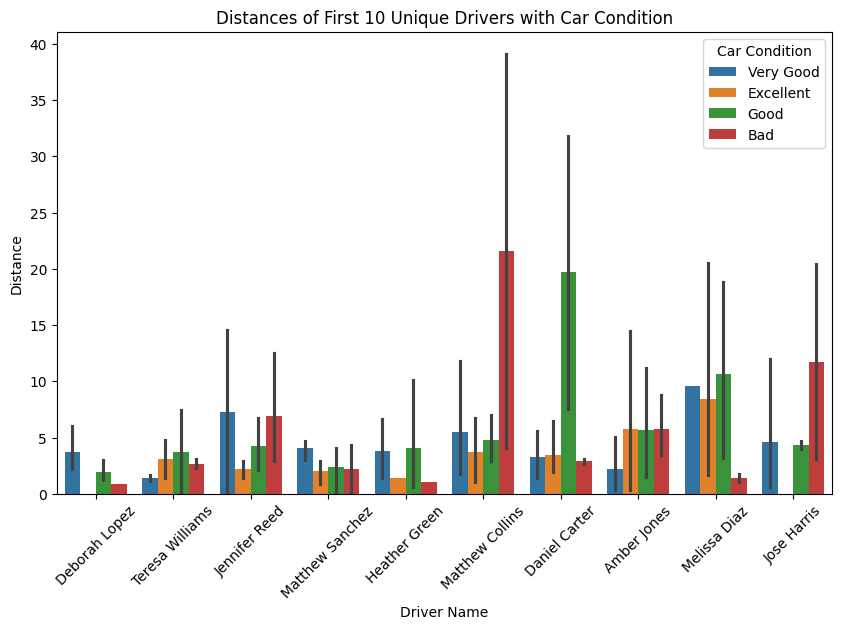

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Driver Name', y='distance', hue='Car Condition', data=filtered_data)
plt.xlabel('Driver Name')
plt.ylabel('Distance')
plt.title('Distances of First 10 Unique Drivers with Car Condition')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(title='Car Condition')
plt.show()

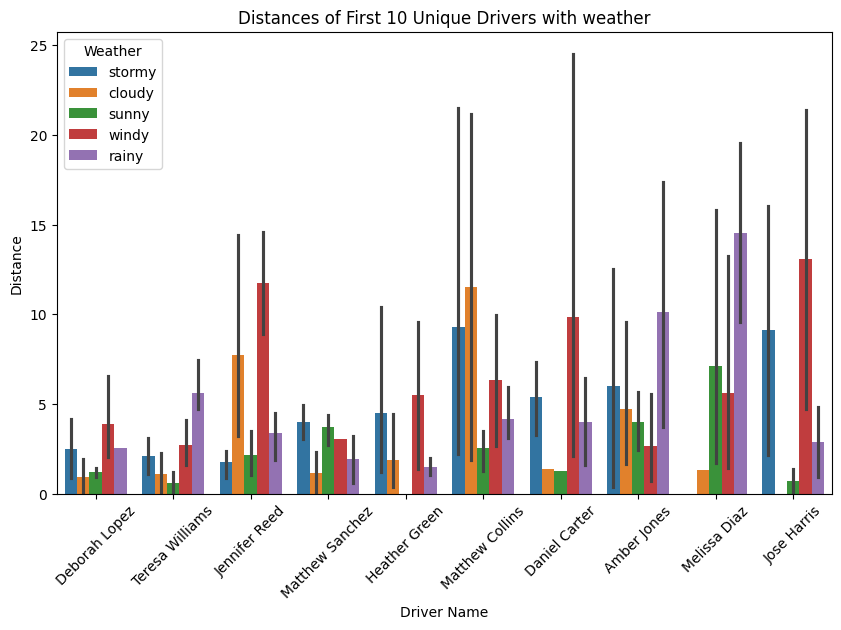

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Driver Name', y='distance', hue='Weather', data=filtered_data)
plt.xlabel('Driver Name')
plt.ylabel('Distance')
plt.title('Distances of First 10 Unique Drivers with weather')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(title='Weather')
plt.show()

In [38]:
car_dist = data.groupby('Car Condition').agg({
        'distance' : 'sum'
    }).reset_index()
car_dist['sum'] = car_dist['distance'].apply(np.sqrt)
car_dist.drop(['distance'],axis= 1,inplace= True)
car_dist

,Car Condition,sum
0,Bad,1577.669980
1,Excellent,1549.944939
2,Good,1513.085373
3,Very Good,1597.964667


In [39]:
weather_dist = data.groupby('Weather').agg({
        'distance' : 'sum'
    }).reset_index()
weather_dist['sum'] = weather_dist['distance'].apply(np.sqrt)
weather_dist.drop(['distance'],axis= 1,inplace= True)
weather_dist.sort_values(by= 'sum', ascending= False, inplace= True)
weather_dist

,Weather,sum
3,sunny,1448.561370
0,cloudy,1434.440831
2,stormy,1397.876113
1,rainy,1386.700500
4,windy,1304.355725


<BarContainer object of 5 artists>

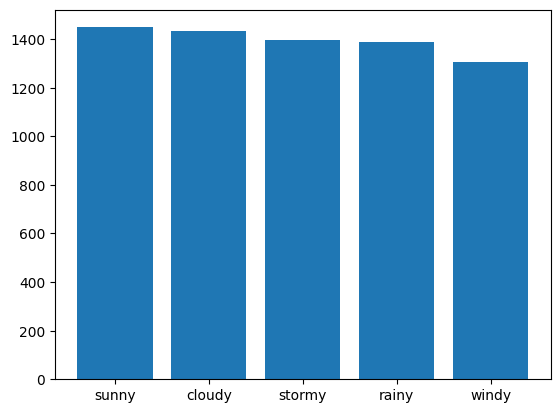

In [40]:
plt.bar(weather_dist['Weather'], weather_dist['sum'])

### Distances.

In [41]:
data.columns

Index(['User Name', 'Driver Name', 'Car Condition', 'Weather',
       'Traffic Condition', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist',
       'nyc_dist', 'distance', 'bearing', 'Car_Condition_coded'],
      dtype='object')

In [42]:
airports_dist = data[['jfk_dist','ewr_dist','lga_dist','sol_dist','nyc_dist']]
airports_dist

,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist
0,20.265840,55.176046,14.342611,34.543548,27.572573
1,44.667679,31.832358,23.130775,15.125872,8.755732
2,43.597686,33.712082,19.865289,17.722624,9.847344
3,42.642965,32.556289,21.063132,15.738963,7.703421
4,43.329953,39.406828,15.219339,23.732406,15.600745
...,...,...,...,...,...
499995,42.565403,36.580043,17.157511,20.401068,12.280187
499996,41.814877,27.833416,26.463167,8.596656,0.994796
499997,31.780108,38.960930,19.708214,19.066488,11.663395
499998,42.292914,36.382813,17.227166,20.006433,11.819775


In [43]:
plt.figure(figsize=(10, 4))
matrix = airports_dist.corr()
matrix

,jfk_dist,ewr_dist,lga_dist,sol_dist,nyc_dist
jfk_dist,1.000000,0.999994,0.999996,0.999994,0.999994
ewr_dist,0.999994,1.000000,0.999994,1.000000,1.000000
lga_dist,0.999996,0.999994,1.000000,0.999993,0.999994
sol_dist,0.999994,1.000000,0.999993,1.000000,1.000000
nyc_dist,0.999994,1.000000,0.999994,1.000000,1.000000


<Figure size 1000x400 with 0 Axes>

Decision here: (for airports distances)
<ul>
    <li>Drop the features.</li>
    <li>Perform PCA.</li>
    <li>Perform Regularization.</li>
</ul>

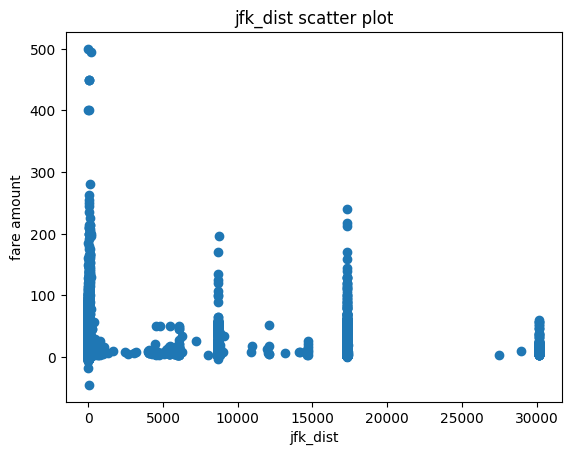

In [44]:
plt.scatter(airports_dist[airports_dist.columns[i]], data['fare_amount'])
plt.title(airports_dist.columns[0] + ' scatter plot')
plt.xlabel(airports_dist.columns[0])
plt.ylabel('fare amount')
plt.show()    

Text(0.5, 1.0, 'Bearing distribution')

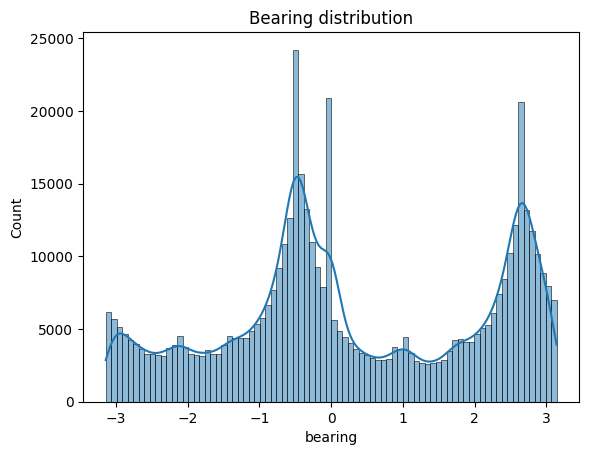

In [45]:
sns.histplot(data= data, x= 'bearing', kde= True)
plt.title('Bearing distribution')

In [46]:
mat = data[['bearing','distance','fare_amount']].corr()
mat

,bearing,distance,fare_amount
bearing,1.000000,-0.017451,-0.024303
distance,-0.017451,1.000000,0.026486
fare_amount,-0.024303,0.026486,1.000000


In [47]:
from sklearn.cluster import KMeans
data_nona = data.dropna()
coordinates = data_nona[['pickup_longitude','pickup_latitude']]
kmeans = KMeans(n_clusters=5, random_state=0)  # Adjust `n_clusters` as needed
kmeans.fit(coordinates)
data_nona['cluster'] = kmeans.labels_

/tmp/ipykernel_21155/2917441127.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona['cluster'] = kmeans.labels_


In [48]:
cluster_counts = data_nona['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

print(cluster_counts)

   cluster   count
0        0  490227
1        1    9765
2        3       1
3        2       1
4        4       1


In [49]:
coordinates = data_nona[['pickup_longitude','pickup_latitude']]
kmeans = KMeans(n_clusters=2, random_state=0)  # Adjust `n_clusters` as needed
kmeans.fit(coordinates)
data_nona['cluster'] = kmeans.labels_

/tmp/ipykernel_21155/3268577024.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona['cluster'] = kmeans.labels_


In [50]:
cluster_counts = data_nona['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

print(cluster_counts)

   cluster   count
0        0  490228
1        1    9767


In [51]:
# Now you can group by cluster and analyze the fare_amount and distance
clustered_summary = data_nona.groupby('cluster').agg({
    'fare_amount': ['mean', 'std'],
    'distance': ['mean', 'std'],
    'User Name': 'count',  # Count of trips in each cluster
    'jfk_dist': ['mean','std'],
    'bearing':'std'
    
}).reset_index().drop(['cluster'],axis=1) # index is the cluster
clustered_summary

/tmp/ipykernel_21155/2023240084.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  }).reset_index().drop(['cluster'],axis=1) # index is the cluster


fare_amount               distance              User Name      jfk_dist  \
         mean        std        mean          std     count          mean   
0   11.347363   9.867218   11.853733   265.634413    490228     50.484080   
1   11.901234  12.105789  401.685131  1793.313201      9767  17189.418208   

                 bearing  
           std       std  
0   267.756017  1.821236  
1  2823.679057  0.399647

In [52]:
data_nona['distance'] = data_nona['distance'].apply(np.sqrt)

/tmp/ipykernel_21155/1005086262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona['distance'] = data_nona['distance'].apply(np.sqrt)


We can see clearly that the customers are mainly two cluster.<br>
One cluster is somehow away from all airports -> maybe that's why they cut longer distances.

In [53]:
data_nona_0 = data_nona[data_nona['cluster'] == 0]
data_nona_1 = data_nona[data_nona['cluster'] == 1]

In [54]:
kmeans = KMeans(n_clusters=3, random_state=0)  # Adjust `n_clusters` as needed
kmeans.fit(data_nona_0[['dropoff_longitude', 'dropoff_latitude']])
data_nona_0['cluster_drop'] = kmeans.labels_
print(data_nona_0.groupby('cluster_drop')['User Name'].agg('count').reset_index())

   cluster_drop  User Name
0             0     489748
1             1          1
2             2        479


/tmp/ipykernel_21155/4159965801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona_0['cluster_drop'] = kmeans.labels_


In [55]:
kmeans = KMeans(n_clusters=3, random_state=0)  # Adjust `n_clusters` as needed
kmeans.fit(data_nona_1[['dropoff_longitude', 'dropoff_latitude']])
data_nona_1['cluster_drop'] = kmeans.labels_
print(data_nona_1.groupby('cluster_drop')['User Name'].agg('count').reset_index())

   cluster_drop  User Name
0             0       9304
1             1        462
2             2          1


/tmp/ipykernel_21155/1554370744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona_1['cluster_drop'] = kmeans.labels_


In [56]:
# Now you can group by cluster and analyze the fare_amount and distance
clustered_summary_2 = data_nona_0.groupby('cluster_drop').agg({
    'fare_amount': ['mean', 'std'],
    'distance': ['mean', 'std'],
    'User Name': 'count',  # Count of trips in each cluster
    'jfk_dist': ['mean','std'],
    'bearing':'std'
    
}).reset_index().drop(['cluster_drop'],axis=1) # index is the cluster
clustered_summary_2

/tmp/ipykernel_21155/1134884396.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  }).reset_index().drop(['cluster_drop'],axis=1) # index is the cluster


fare_amount               distance           User Name      jfk_dist  \
         mean        std        mean       std     count          mean   
0   11.342327   9.846243    1.648907  0.978331    489748     42.292159   
1    4.100000        NaN  111.355092       NaN         1  27503.603940   
2   16.511315  22.238722   91.210161  5.287709       479   8368.906050   

                bearing  
          std       std  
0   40.996793  1.821049  
1         NaN       NaN  
2  904.839668  0.194709

In [57]:
# Now you can group by cluster and analyze the fare_amount and distance
clustered_summary_3 = data_nona_1.groupby('cluster_drop').agg({
    'fare_amount': ['mean', 'std'],
    'distance': ['mean', 'std'],
    'User Name': 'count',  # Count of trips in each cluster
    'jfk_dist': ['mean','std'],
    'bearing':'std'
    
}).reset_index().drop(['cluster_drop'],axis=1) # index is the cluster
print(clustered_summary_3)

  fare_amount              distance           User Name      jfk_dist  \
         mean        std       mean       std     count          mean   
0   11.774987  12.038144   0.125854  2.338081      9304  17625.474884   
1   14.448420  13.164720  91.375971  5.075306       462   8382.532226   
2    9.700000        NaN  53.666096       NaN         1  28899.430976   

                 bearing  
           std       std  
0  2068.171260  0.355964  
1   851.641693  0.099782  
2          NaN       NaN  


/tmp/ipykernel_21155/153616074.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  }).reset_index().drop(['cluster_drop'],axis=1) # index is the cluster


Cluster 0 is the cluster close to all airports:<br>
within this cluster, there are who have drop off away from jfk than the others that's why they cut higher distaces.<br>
Cluster 1 is the cluster away from all airports:<br>
within this cluster, there are who have drop off near to jfk than the others that's why they cut smaller distaces.

In [58]:
data.columns

Index(['User Name', 'Driver Name', 'Car Condition', 'Weather',
       'Traffic Condition', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist',
       'nyc_dist', 'distance', 'bearing', 'Car_Condition_coded'],
      dtype='object')

In [59]:
trips_per_year = data.groupby('year').agg({
        'year' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_year.columns = ['year','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']

trips_per_year

,year,number_of_trips,fare_amount_mean,fare_amount_std,passenger_count_mean,passenger_count_std,distance_mean,distance_std,jfk_dist_mean,jfk_dist_std
0,2009,77002,10.018505,8.176336,1.685593,1.249990,6.191695,160.667634,268.322093,1955.515911
1,2010,75791,10.197785,8.439440,1.671650,1.242954,7.195368,182.693586,398.530736,2446.551870
2,2011,79529,10.481498,9.156279,1.654554,1.262034,17.903723,344.430314,432.522116,2540.597180
3,2012,80225,11.157711,9.841385,1.684699,1.335141,25.964616,418.842627,432.034183,2522.662589
4,2013,78034,12.626578,10.797816,1.712369,1.379392,16.794015,338.687852,414.264399,2718.088635
5,2014,74608,12.965165,11.193553,1.692218,1.352619,34.484834,518.182200,389.028080,2367.267717
6,2015,34811,13.027985,12.009427,1.683606,1.339297,37.978245,546.250738,326.454588,2129.262015


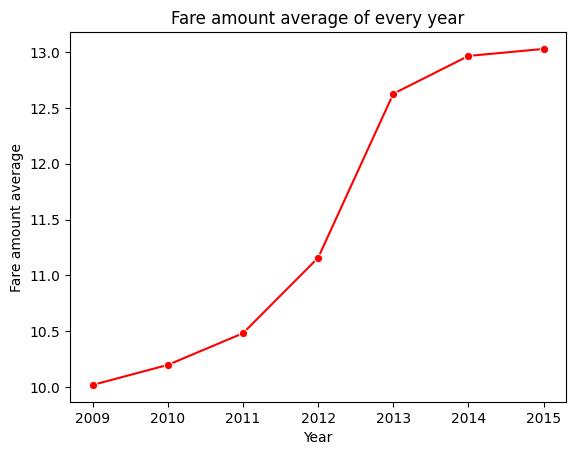

In [60]:
sns.lineplot(x= trips_per_year['year'], y= trips_per_year['fare_amount_mean'], marker='o', color='r')
plt.title('Fare amount average of every year')
plt.xlabel('Year')
plt.ylabel('Fare amount average')
plt.show()

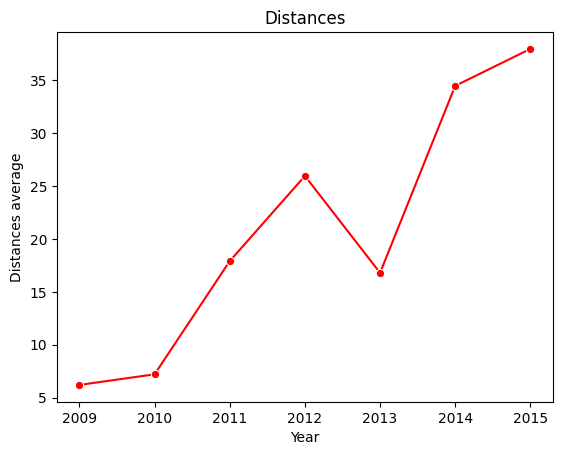

In [61]:
sns.lineplot(x= trips_per_year['year'], y= trips_per_year['distance_mean'], marker='o', color='r')
plt.title('Distances')
plt.xlabel('Year')
plt.ylabel('Distances average')
plt.show()

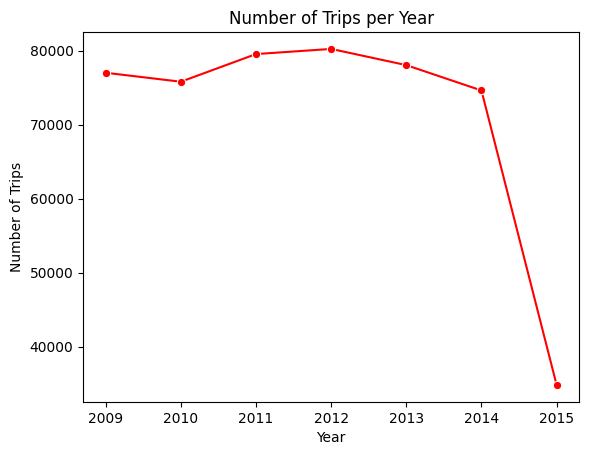

In [62]:
sns.lineplot(data= trips_per_year, x= 'year', y= 'number_of_trips', marker='o', color='r')
plt.title('Number of Trips per Year')
plt.xlabel('Year')
plt.ylabel('Number of Trips')
plt.show()

In [63]:
trips_per_month = data.groupby('month').agg({
        'month' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_month.columns = ['month','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']

trips_per_month

,month,number_of_trips,fare_amount_mean,fare_amount_std,passenger_count_mean,passenger_count_std,distance_mean,distance_std,jfk_dist_mean,jfk_dist_std
0,1,44547,10.792074,9.391208,1.684850,1.310884,15.087962,317.384729,346.492937,2248.273113
1,2,42454,10.882676,9.313493,1.662388,1.296448,20.529798,381.436851,383.692875,2371.143860
2,3,46715,11.158100,9.925334,1.666831,1.300279,19.246675,363.874690,372.798291,2336.878120
3,4,45959,11.270379,9.514545,1.676211,1.306825,20.060011,372.889343,370.915591,2327.146438
4,5,46733,11.677835,10.537665,1.686517,1.303176,21.416911,386.601744,514.311894,3122.075521
5,6,44827,11.545656,9.925150,1.685792,1.312683,19.782397,365.576725,375.907561,2352.663193
6,7,38127,11.154873,9.741806,1.695885,1.309467,19.827389,370.389401,412.830437,2476.673633
7,8,35871,11.206067,9.692578,1.692565,1.306304,23.758530,415.659910,409.890273,2456.661789
8,9,37980,11.819406,10.608015,1.694365,1.319377,22.450612,402.072555,359.743760,2283.294901
9,10,40551,11.666560,10.432002,1.675914,1.297564,18.547913,358.406202,328.316897,2172.735521


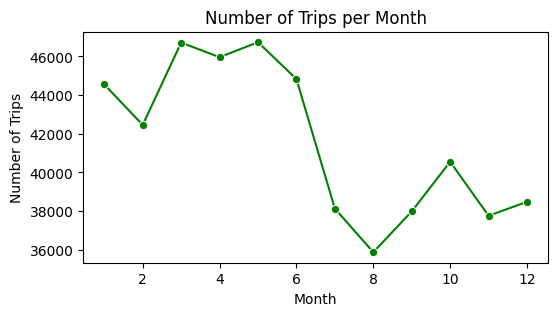

In [64]:
plt.figure(figsize=(6,3))
sns.lineplot(data= trips_per_month, x= 'month', y= 'number_of_trips', marker='o', color='g')
plt.title('Number of Trips per Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.show()

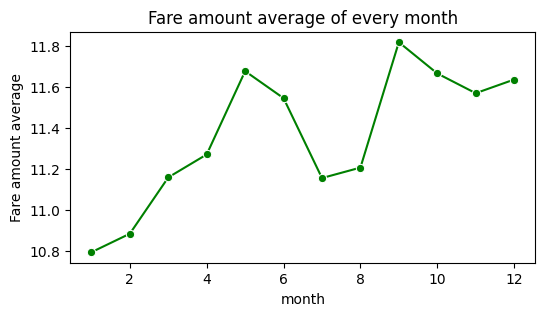

In [65]:
plt.figure(figsize=(6,3))
sns.lineplot(x= trips_per_month['month'], y= trips_per_month['fare_amount_mean'], marker='o', color='g')
plt.title('Fare amount average of every month')
plt.xlabel('month')
plt.ylabel('Fare amount average')
plt.show()

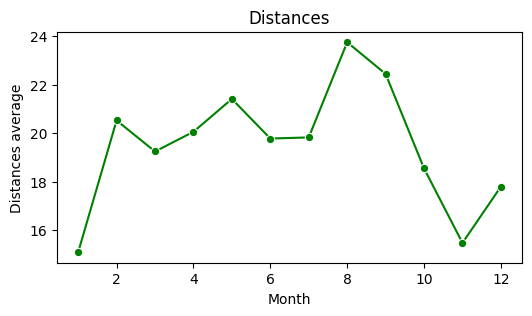

In [66]:
plt.figure(figsize=(6,3))
sns.lineplot(x= trips_per_month['month'], y= trips_per_month['distance_mean'], marker='o', color='g')
plt.title('Distances')
plt.xlabel('Month')
plt.ylabel('Distances average')
plt.show()

Trips are more in the fall season, less in the rest and very low in spring and winter. However, the fare amounts are somehow higher, which indicates that during time where number of trips are down, the captains tend to increase the fare.

In [67]:
trips_per_day = data.groupby('day').agg({
        'day' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_day.columns = ['day','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']

trips_per_day

,day,number_of_trips,fare_amount_mean,fare_amount_std,passenger_count_mean,passenger_count_std,distance_mean,distance_std,jfk_dist_mean,jfk_dist_std
0,1,15573,11.373487,9.985744,1.677005,1.301645,21.160619,389.370382,353.833642,2265.046076
1,2,15713,11.370785,9.683693,1.679947,1.308981,25.724065,431.192590,385.935461,2369.885461
2,3,15863,11.271819,9.673723,1.678056,1.293633,19.551644,361.179776,384.217317,2373.458112
3,4,15767,11.247535,9.633247,1.682248,1.311404,22.312537,399.768019,372.401298,2328.039640
4,5,16045,11.300751,10.016764,1.689623,1.302059,14.200059,303.765673,374.327235,2351.086974
5,6,16451,11.442294,10.094924,1.663668,1.289473,13.717328,297.948532,349.676282,2262.884611
6,7,16642,11.342685,9.779744,1.665845,1.293500,17.455074,343.410095,373.434489,2340.421496
7,8,16807,11.201462,10.038235,1.674957,1.298286,19.895913,374.267015,377.478439,2351.250025
8,9,16963,11.155014,9.378794,1.662854,1.289963,19.095870,359.429881,370.205212,2326.483444
9,10,16763,11.389937,9.853088,1.684543,1.307871,17.387264,341.626746,367.769134,2321.558189


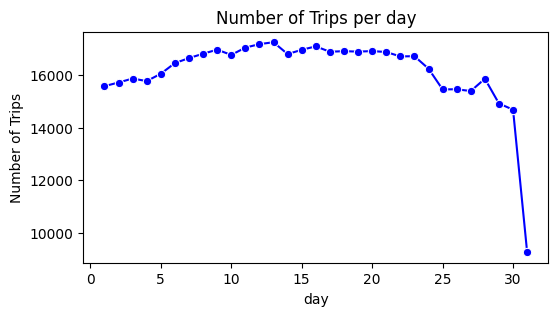

In [68]:
plt.figure(figsize=(6,3))
sns.lineplot(data= trips_per_day, x= 'day', y= 'number_of_trips', marker='o', color='b')
plt.title('Number of Trips per day')
plt.xlabel('day')
plt.ylabel('Number of Trips')
plt.show()

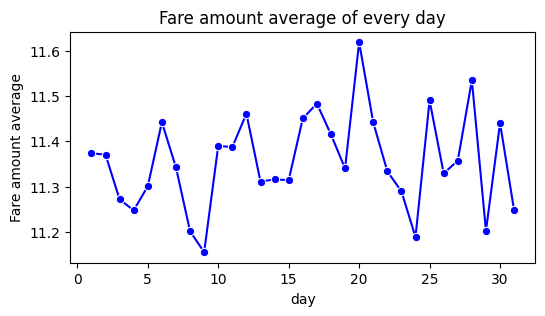

In [69]:
plt.figure(figsize=(6,3))
sns.lineplot(x= trips_per_day['day'], y= trips_per_day['fare_amount_mean'], marker='o', color='b')
plt.title('Fare amount average of every day')
plt.xlabel('day')
plt.ylabel('Fare amount average')
plt.show()

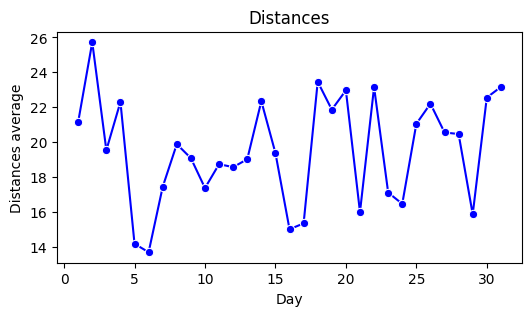

In [70]:
plt.figure(figsize=(6,3))
sns.lineplot(x= trips_per_day['day'], y= trips_per_day['distance_mean'], marker='o', color='b')
plt.title('Distances')
plt.xlabel('Day')
plt.ylabel('Distances average')
plt.show()

No effect by the day on the number of trips or distance, or fare amounts

In [71]:
trips_per_hour = data.groupby('hour').agg({
        'hour' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_hour.columns = ['hour','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']

trips_per_hour

,hour,number_of_trips,fare_amount_mean,fare_amount_std,passenger_count_mean,passenger_count_std,distance_mean,distance_std,jfk_dist_mean,jfk_dist_std
0,0,19650,11.774804,9.424157,1.744326,1.310696,25.009558,423.394247,424.228939,2566.222712
1,1,14556,11.438250,8.787547,1.743405,1.307396,15.515779,317.882655,421.754780,2575.220475
2,2,10884,11.511949,9.162187,1.733921,1.293309,18.173196,346.116565,417.523146,2515.130561
3,3,7936,12.076379,10.192270,1.768901,1.338404,21.091953,382.619707,432.207749,2576.443750
4,4,5864,13.687069,11.723675,1.714700,1.325030,38.850043,538.364386,441.866501,2554.746586
5,5,4982,15.166068,15.442092,1.606784,1.306224,19.049514,346.839763,442.899342,2637.611321
6,6,10326,12.314031,12.669265,1.522080,1.241044,16.930849,323.521276,371.988713,2381.002341
7,7,18231,10.952701,9.737444,1.559322,1.278790,22.051665,396.148300,390.533595,2432.725084
8,8,22599,10.913638,9.540923,1.579406,1.276515,18.482218,363.920436,377.383188,2396.121861
9,9,23566,10.818004,9.333114,1.613469,1.320232,18.500844,355.320217,353.919480,2301.617777


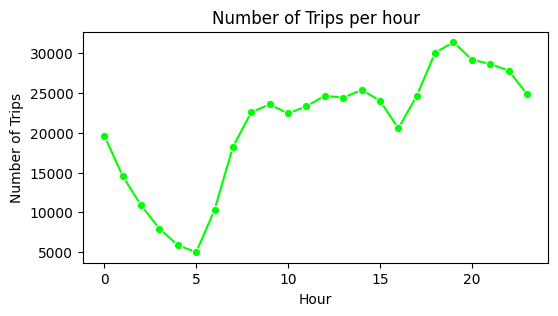

In [72]:
plt.figure(figsize=(6,3))
sns.lineplot(data= trips_per_hour, x= 'hour', y= 'number_of_trips', marker='o', color='lime')
plt.title('Number of Trips per hour')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.show()

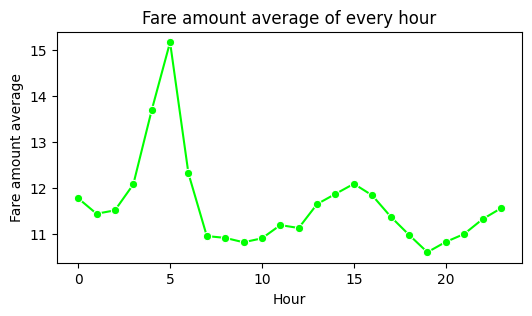

In [73]:
plt.figure(figsize=(6,3))
sns.lineplot(x= trips_per_hour['hour'], y= trips_per_hour['fare_amount_mean'], marker='o', color='lime')
plt.title('Fare amount average of every hour')
plt.xlabel('Hour')
plt.ylabel('Fare amount average')
plt.show()

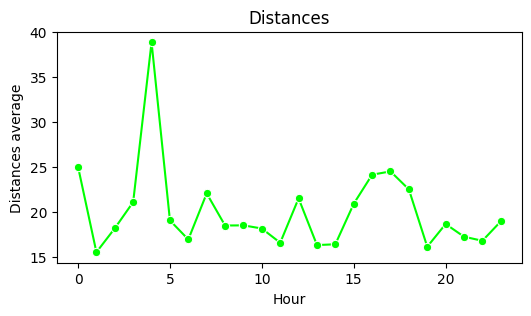

In [74]:
plt.figure(figsize=(6,3))
sns.lineplot(x= trips_per_hour['hour'], y= trips_per_hour['distance_mean'], marker='o', color='lime')
plt.title('Distances')
plt.xlabel('Hour')
plt.ylabel('Distances average')
plt.show()

In [75]:
print(data[['distance','fare_amount']].corr())

             distance  fare_amount
distance     1.000000     0.026486
fare_amount  0.026486     1.000000


The dusk and dawn are the highest in fare amounts and distances taken<br>
That made me re-visit the idea that the distance and fare amount could be correlated but there is nearly no correlation.

In [76]:
trips_per_hour_0 = data_nona_0.groupby('hour').agg({
        'hour' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_hour_0.columns = ['hour','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']
trips_per_hour_1 = data_nona_1.groupby('hour').agg({
        'hour' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_hour_1.columns = ['hour','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']


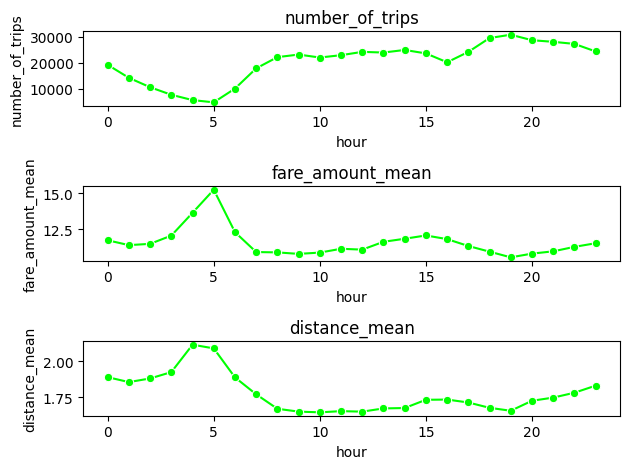

In [77]:
fig, axes= plt.subplots(nrows=3, ncols= 1)
plot_cols = ['number_of_trips','fare_amount_mean','distance_mean']
for i, ax in enumerate(axes):
    sns.lineplot(x= trips_per_hour_0['hour'], y= trips_per_hour_0[plot_cols[i]],ax=ax ,marker='o', color='lime')
    set_title_(axes= axes, i= i, column=plot_cols[i])
    set_labels_(axes= axes, i= i, label_x= 'hour', label_y= plot_cols[i])
    
plt.tight_layout()
plt.show()

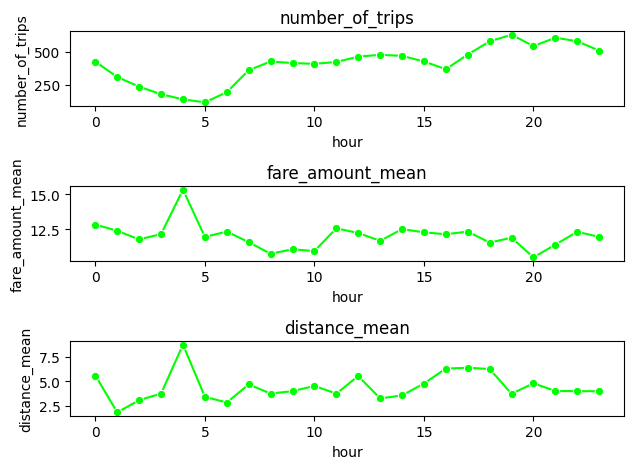

In [78]:
fig, axes= plt.subplots(nrows=3, ncols= 1)
plot_cols = ['number_of_trips','fare_amount_mean','distance_mean']
for i, ax in enumerate(axes):
    sns.lineplot(x= trips_per_hour_1['hour'], y= trips_per_hour_1[plot_cols[i]],ax=ax ,marker='o', color='lime')
    set_title_(axes= axes, i= i, column=plot_cols[i])
    set_labels_(axes= axes, i= i, label_x= 'hour', label_y= plot_cols[i])
    
plt.tight_layout()
plt.show()

In [79]:
data_nona_1.columns

Index(['User Name', 'Driver Name', 'Car Condition', 'Weather',
       'Traffic Condition', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_dist', 'ewr_dist', 'lga_dist', 'sol_dist',
       'nyc_dist', 'distance', 'bearing', 'Car_Condition_coded', 'cluster',
       'cluster_drop'],
      dtype='object')

In [80]:
trips_per_month_0 = data_nona_0.groupby('month').agg({
        'month' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_month_0.columns = ['month','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']
trips_per_month_1 = data_nona_1.groupby('month').agg({
        'month' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_month_1.columns = ['month','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']


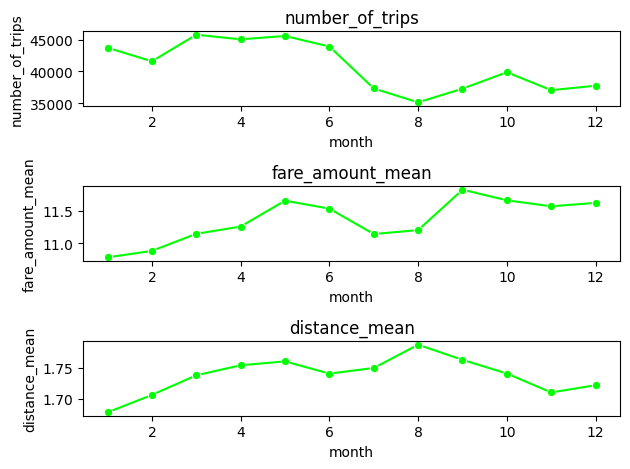

In [81]:
fig, axes= plt.subplots(nrows=3, ncols= 1)
plot_cols = ['number_of_trips','fare_amount_mean','distance_mean']
for i, ax in enumerate(axes):
    sns.lineplot(x= trips_per_month_0['month'], y= trips_per_month_0[plot_cols[i]],ax=ax ,marker='o', color='lime')
    set_title_(axes= axes, i= i, column=plot_cols[i])
    set_labels_(axes= axes, i= i, label_x= 'month', label_y= plot_cols[i])
    
plt.tight_layout()
plt.show()

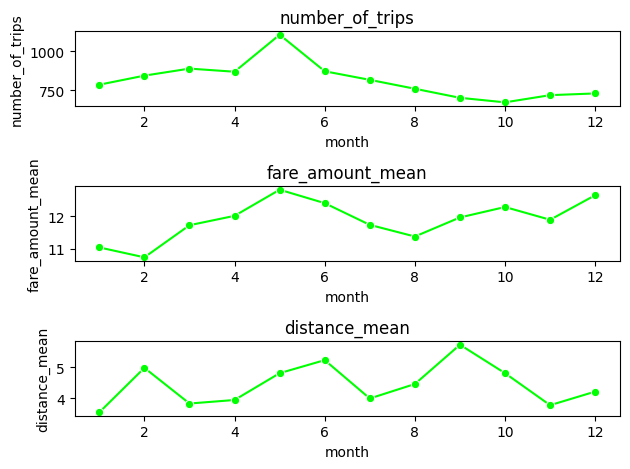

In [82]:
fig, axes= plt.subplots(nrows=3, ncols= 1)
plot_cols = ['number_of_trips','fare_amount_mean','distance_mean']
for i, ax in enumerate(axes):
    sns.lineplot(x= trips_per_month_1['month'], y= trips_per_month_1[plot_cols[i]],ax=ax ,marker='o', color='lime')
    set_title_(axes= axes, i= i, column=plot_cols[i])
    set_labels_(axes= axes, i= i, label_x= 'month', label_y= plot_cols[i])
    
plt.tight_layout()
plt.show()

In [83]:
trips_per_year_0 = data_nona_0.groupby('year').agg({
        'year' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_year_0.columns = ['year','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']
trips_per_year_1 = data_nona_1.groupby('year').agg({
        'year' : 'count',
        'fare_amount':['mean','std'],
        'passenger_count':['mean','std'],
        'distance':['mean','std'],
        'jfk_dist':['mean','std']
    }).reset_index()
trips_per_year_1.columns = ['year','number_of_trips' ,
                          'fare_amount_mean', 'fare_amount_std', 
                          'passenger_count_mean', 'passenger_count_std', 
                          'distance_mean', 'distance_std', 
                          'jfk_dist_mean', 'jfk_dist_std']


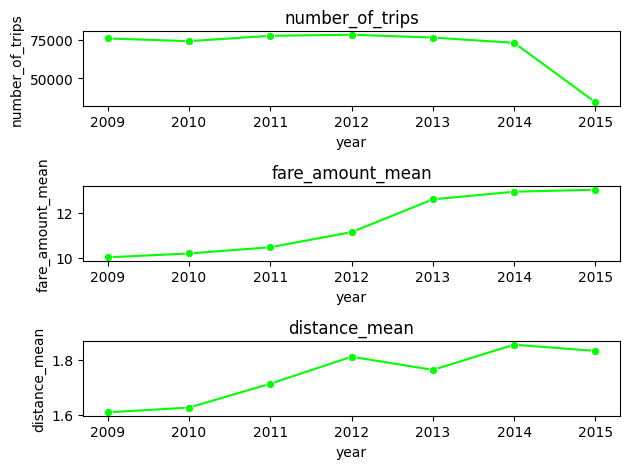

In [84]:
fig, axes= plt.subplots(nrows=3, ncols= 1)
plot_cols = ['number_of_trips','fare_amount_mean','distance_mean']
for i, ax in enumerate(axes):
    sns.lineplot(x= trips_per_year_0['year'], y= trips_per_year_0[plot_cols[i]],ax=ax ,marker='o', color='lime')
    set_title_(axes= axes, i= i, column=plot_cols[i])
    set_labels_(axes= axes, i= i, label_x= 'year', label_y= plot_cols[i])
    
plt.tight_layout()
plt.show()

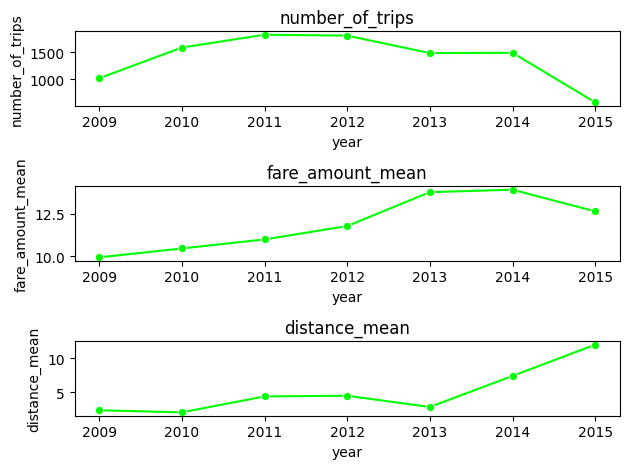

In [85]:
fig, axes= plt.subplots(nrows=3, ncols= 1)
plot_cols = ['number_of_trips','fare_amount_mean','distance_mean']
for i, ax in enumerate(axes):
    sns.lineplot(x= trips_per_year_1['year'], y= trips_per_year_1[plot_cols[i]],ax=ax ,marker='o', color='lime')
    set_title_(axes= axes, i= i, column=plot_cols[i])
    set_labels_(axes= axes, i= i, label_x= 'year', label_y= plot_cols[i])
    
plt.tight_layout()
plt.show()

In [86]:
vals = data['passenger_count'].value_counts()
vals

passenger_count
1    346009
2     73908
5     35322
3     21761
4     10614
6     10590
0      1796
Name: count, dtype: int64

<Axes: xlabel='passenger_count', ylabel='count'>

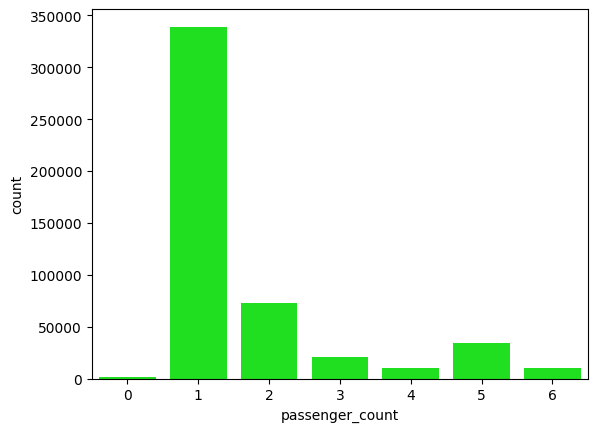

In [87]:
sns.countplot(x='passenger_count', data= data_nona_0, color= 'lime')

What is this 0, maybe garbage.

In [88]:
kmeans = KMeans(n_clusters=2, random_state=0)  # Adjust `n_clusters` as needed
kmeans.fit(data_nona[['dropoff_longitude', 'dropoff_latitude']])
data_nona['cluster_drop'] = kmeans.labels_
print(data_nona.groupby('cluster_drop')['User Name'].agg('count').reset_index())

   cluster_drop  User Name
0             0     490212
1             1       9783


/tmp/ipykernel_21155/3328097814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nona['cluster_drop'] = kmeans.labels_


In [89]:
data_cleaned = data_nona[data_nona['fare_amount'] > 0][['passenger_count','month','cluster','cluster_drop',
                            'year','day','weekday','jfk_dist','distance','pickup_longitude','pickup_latitude'
                            ,'bearing','dropoff_longitude','dropoff_latitude','Car Condition', 
                            'Weather','Traffic Condition', 'fare_amount']][data_nona['passenger_count'] > 0].reset_index().drop(['index'],axis= 1)
data_cleaned = drop_outliers_df(data_cleaned, ['jfk_dist','distance','fare_amount'])
data_cleaned

/tmp/ipykernel_21155/1996368843.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_cleaned = data_nona[data_nona['fare_amount'] > 0][['passenger_count','month','cluster','cluster_drop',


,passenger_count,month,cluster,cluster_drop,year,day,weekday,jfk_dist,distance,pickup_longitude,pickup_latitude,bearing,dropoff_longitude,dropoff_latitude,Car Condition,Weather,Traffic Condition,fare_amount
0,1,6,0,0,2009,15,0,20.265840,1.015265,-1.288826,0.710721,-2.918897,-1.288779,0.710563,Very Good,windy,Congested Traffic,4.5
1,1,1,0,0,2010,5,1,44.667679,2.906911,-1.291824,0.710546,-0.375217,-1.291182,0.711780,Excellent,cloudy,Flow Traffic,16.9
2,2,8,0,0,2011,18,3,43.597686,1.178781,-1.291242,0.711418,2.599961,-1.291391,0.711231,Bad,stormy,Congested Traffic,5.7
3,1,4,0,0,2012,21,5,42.642965,1.673102,-1.291319,0.710927,0.133905,-1.291396,0.711363,Very Good,stormy,Flow Traffic,7.7
4,1,3,0,0,2010,9,1,43.329953,1.413915,-1.290987,0.711536,-0.502703,-1.290787,0.711811,Bad,stormy,Congested Traffic,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498164,1,5,0,0,2015,7,3,42.565403,1.185204,-1.291173,0.711514,-2.275706,-1.290951,0.711371,Bad,rainy,Dense Traffic,7.0
498165,1,9,0,0,2010,13,0,41.814877,0.997088,-1.291595,0.710670,2.556931,-1.291708,0.710540,Very Good,rainy,Flow Traffic,13.7
498166,1,8,0,0,2014,25,0,31.780108,2.803449,-1.291262,0.710796,-1.926251,-1.289737,0.710366,Bad,rainy,Flow Traffic,25.0
498167,6,1,0,0,2015,12,0,42.292914,0.997231,-1.291101,0.711335,-0.384817,-1.291023,0.711480,Good,stormy,Congested Traffic,6.5


Relations among variables are non-linear, that's why it is better to use Spearman coeffecient.

In [90]:
data_num  = data_cleaned[['passenger_count','jfk_dist','distance','bearing',
                          'pickup_latitude','pickup_longitude','dropoff_latitude',
                           'dropoff_longitude','fare_amount']]
print(data_num.corr())

                   passenger_count  jfk_dist  distance   bearing  \
passenger_count           1.000000 -0.004786  0.011384  0.001436   
jfk_dist                 -0.004786  1.000000 -0.446657  0.103353   
distance                  0.011384 -0.446657  1.000000  0.003549   
bearing                   0.001436  0.103353  0.003549  1.000000   
pickup_latitude          -0.006431  0.499955 -0.168377  0.174776   
pickup_longitude          0.003159 -0.487740  0.336322  0.244957   
dropoff_latitude         -0.003008  0.508254 -0.115616 -0.077161   
dropoff_longitude         0.000003 -0.439276  0.357574 -0.363912   
fare_amount               0.016679 -0.532853  0.832785 -0.033206   

                   pickup_latitude  pickup_longitude  dropoff_latitude  \
passenger_count          -0.006431          0.003159         -0.003008   
jfk_dist                  0.499955         -0.487740          0.508254   
distance                 -0.168377          0.336322         -0.115616   
bearing                

In [91]:
data_num_filtered = data_num[[feature for feature in data_num.columns if Spearman(feature1=feature, feature2='fare_amount')]]
data_num_filtered

passenger_count
Spearman correlation coefficient: 0.024031748259596426 for feature passenger_count for P-value: 1.2266861471272628e-62
jfk_dist
Spearman correlation coefficient: -0.1811057983842689 for feature jfk_dist for P-value: 0.0
distance
Spearman correlation coefficient: 0.8479979643154996 for feature distance for P-value: 0.0
bearing
Spearman correlation coefficient: -0.010776005343430907 for feature bearing for P-value: 6.923943739882904e-14
pickup_latitude
Spearman correlation coefficient: -0.06559329502326325 for feature pickup_latitude for P-value: 0.0
pickup_longitude
Spearman correlation coefficient: 0.030229782432324204 for feature pickup_longitude for P-value: 4.900954988390334e-98
dropoff_latitude
Spearman correlation coefficient: -0.07659316124682715 for feature dropoff_latitude for P-value: 0.0
dropoff_longitude
Spearman correlation coefficient: 0.106017821015333 for feature dropoff_longitude for P-value: 0.0
fare_amount
Spearman correlation coefficient: 0.9999999999

,jfk_dist,distance,fare_amount
0,20.265840,1.015265,4.5
1,44.667679,2.906911,16.9
2,43.597686,1.178781,5.7
3,42.642965,1.673102,7.7
4,43.329953,1.413915,5.3
...,...,...,...
498164,42.565403,1.185204,7.0
498165,41.814877,0.997088,13.7
498166,31.780108,2.803449,25.0
498167,42.292914,0.997231,6.5


In [92]:
coordinates = data_cleaned[['pickup_longitude','pickup_latitude']]
kmeans = KMeans(n_clusters=5, random_state=0)  # Adjust `n_clusters` as needed
kmeans.fit(coordinates)
data_cleaned['cluster'] = kmeans.labels_
cluster_counts = data_cleaned['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

print(cluster_counts)

   cluster   count
0        4  210427
1        0  144901
2        1  110057
3        2   12968
4        3    4644


In [93]:
# Define the directory and filename
model_directory = os.getenv('Model_Dir')
model_filename = os.getenv('KMeansPick')
# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

# Combine the directory and filename
model_path = os.path.join(model_directory, model_filename)

# Save the model
dump(kmeans, model_path)

print(f"Model saved to {model_path}")

Model saved to /home/ziad/MachineLearning/Projects/Car-travels/Models/cluster_pick.joblib


In [94]:
kmeans2 = KMeans(n_clusters=5, random_state=0)  # Adjust `n_clusters` as needed
kmeans2.fit(data_cleaned[['dropoff_longitude', 'dropoff_latitude']])
data_cleaned['cluster_drop'] = kmeans2.labels_
cluster_counts = data_cleaned['cluster_drop'].value_counts().reset_index()
cluster_counts.columns = ['cluster_drop', 'count']

print(cluster_counts)

   cluster_drop   count
0             0  235343
1             1  114268
2             3  112748
3             2   16506
4             4    4132


In [95]:
# Define the directory and filename
model_directory = os.getenv('Model_Dir')
model_filename = os.getenv('KMeansDrop')
# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

# Combine the directory and filename
model_path = os.path.join(model_directory, model_filename)

# Save the model
dump(kmeans2, model_path)

print(f"Model saved to {model_path}")

Model saved to /home/ziad/MachineLearning/Projects/Car-travels/Models/cluster_drop.joblib


In [96]:
data_cat = data_cleaned[['Car Condition','Weather', 'Traffic Condition','day','year','cluster','cluster_drop', 'fare_amount']]

In [97]:
scaler = StandardScaler()
data_cat['month'] = scaler.fit_transform(data_cleaned[['month']])
# Cyclical Encoding for month
data_cat['month_sin'] = np.sin(2 * np.pi * data_cat['month'] / 12)
data_cat.drop(['month'], axis=1, inplace= True)
data_cat.rename(columns={'Car Condition' : 'car_cond','Traffic Condition' : 'traffic_cond'}, inplace= True)
data_cat

/tmp/ipykernel_21155/1462808775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cat['month'] = scaler.fit_transform(data_cleaned[['month']])
/tmp/ipykernel_21155/1462808775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cat['month_sin'] = np.sin(2 * np.pi * data_cat['month'] / 12)
/tmp/ipykernel_21155/1462808775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

,car_cond,Weather,traffic_cond,day,year,cluster,cluster_drop,fare_amount,month_sin
0,Very Good,windy,Congested Traffic,15,2009,2,2,4.5,-0.041301
1,Excellent,cloudy,Flow Traffic,5,2010,0,1,16.9,-0.719007
2,Bad,stormy,Congested Traffic,18,2011,4,0,5.7,0.260086
3,Very Good,stormy,Flow Traffic,21,2012,0,0,7.7,-0.338890
4,Bad,stormy,Congested Traffic,9,2010,1,1,5.3,-0.477624
...,...,...,...,...,...,...,...,...,...
498164,Bad,rainy,Dense Traffic,7,2015,4,0,7.0,-0.192319
498165,Very Good,rainy,Flow Traffic,13,2010,0,3,13.7,0.403486
498166,Bad,rainy,Flow Traffic,25,2014,0,2,25.0,0.260086
498167,Good,stormy,Congested Traffic,12,2015,4,0,6.5,-0.719007


In [98]:
# Define the directory and filename
model_directory = os.getenv('Model_Dir')
model_filename = os.getenv('Scaler')
# Create the directory if it doesn't exist
os.makedirs(model_directory, exist_ok=True)

# Combine the directory and filename
model_path = os.path.join(model_directory, model_filename)
dump(scaler, model_path) # save the model

['/home/ziad/MachineLearning/Projects/Car-travels/Models/scaler.joblib']

In [99]:
data_cat['cluster'].value_counts()

cluster
4    210427
0    144901
1    110057
2     12968
3      4644
Name: count, dtype: int64

In [100]:
# Filter categorical columns based on ANOVA significance
significant_columns = [
    feature for feature in data_cat.columns
    if feature != 'fare_amount' and is_significant_anova(data=data_cat, numerical_col='fare_amount',
                                                         dof1= len(list(data_cat[feature].value_counts().items())), categorical_col=feature)
]

# Create a new DataFrame with only significant categorical columns
data_cat_filtered = data_cat[significant_columns + ['fare_amount']]
data_cat_filtered

/tmp/ipykernel_21155/3914324891.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/tmp/ipykernel_21155/3914324891.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]


For feature car_cond the p value is 0.08444829335488378, Critical is 1.686229054214775 and F-statistic 2.2120333107530414


/tmp/ipykernel_21155/3914324891.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/tmp/ipykernel_21155/3914324891.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]


For feature Weather the p value is 0.9596066927243323, Critical is 1.6230484770057887 and F-statistic 0.15764258049892432


/tmp/ipykernel_21155/3914324891.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/tmp/ipykernel_21155/3914324891.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]


For feature traffic_cond the p value is 0.4678614792244533, Critical is 1.772357199465742 and F-statistic 0.7595842061108661


/tmp/ipykernel_21155/3914324891.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/tmp/ipykernel_21155/3914324891.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]


For feature day the p value is 0.00017972848889674244, Critical is 1.2620896368467402 and F-statistic 2.1892188466357902


/tmp/ipykernel_21155/3914324891.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/tmp/ipykernel_21155/3914324891.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]


For feature year the p value is 0.0, Critical is 1.5354227550573878 and F-statistic 1293.8187874418848


/tmp/ipykernel_21155/3914324891.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/tmp/ipykernel_21155/3914324891.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]


For feature cluster the p value is 0.0, Critical is 1.6230484770057887 and F-statistic 45508.86763947181


/tmp/ipykernel_21155/3914324891.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/tmp/ipykernel_21155/3914324891.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]


For feature cluster_drop the p value is 0.0, Critical is 1.6230484770057887 and F-statistic 34442.077314520255
For feature month_sin the p value is 9.858768734178471e-113, Critical is 1.4157858003866999 and F-statistic 50.81209332983681


/tmp/ipykernel_21155/3914324891.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]
/tmp/ipykernel_21155/3914324891.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]


,car_cond,day,year,cluster,cluster_drop,month_sin,fare_amount
0,Very Good,15,2009,2,2,-0.041301,4.5
1,Excellent,5,2010,0,1,-0.719007,16.9
2,Bad,18,2011,4,0,0.260086,5.7
3,Very Good,21,2012,0,0,-0.338890,7.7
4,Bad,9,2010,1,1,-0.477624,5.3
...,...,...,...,...,...,...,...
498164,Bad,7,2015,4,0,-0.192319,7.0
498165,Very Good,13,2010,0,3,0.403486,13.7
498166,Bad,25,2014,0,2,0.260086,25.0
498167,Good,12,2015,4,0,-0.719007,6.5


In [101]:
data_cleaned = pd.concat([data_num_filtered.drop(['fare_amount'],axis= 1), data_cat_filtered],axis= 1)
data_cleaned

,jfk_dist,distance,car_cond,day,year,cluster,cluster_drop,month_sin,fare_amount
0,20.265840,1.015265,Very Good,15,2009,2,2,-0.041301,4.5
1,44.667679,2.906911,Excellent,5,2010,0,1,-0.719007,16.9
2,43.597686,1.178781,Bad,18,2011,4,0,0.260086,5.7
3,42.642965,1.673102,Very Good,21,2012,0,0,-0.338890,7.7
4,43.329953,1.413915,Bad,9,2010,1,1,-0.477624,5.3
...,...,...,...,...,...,...,...,...,...
498164,42.565403,1.185204,Bad,7,2015,4,0,-0.192319,7.0
498165,41.814877,0.997088,Very Good,13,2010,0,3,0.403486,13.7
498166,31.780108,2.803449,Bad,25,2014,0,2,0.260086,25.0
498167,42.292914,0.997231,Good,12,2015,4,0,-0.719007,6.5


In [102]:
condition_map = {
    'Excellent': 3,
    'Very Good': 2,
    'Good': 1,
    'Bad': 0
}
data_cleaned['Car_Condition_coded'] = data_cleaned['car_cond'].map(condition_map)
data_cleaned['Car_Condition_coded']

0         2
1         3
2         0
3         2
4         0
         ..
498164    0
498165    2
498166    0
498167    1
498168    2
Name: Car_Condition_coded, Length: 482997, dtype: int64

In [103]:
data_cleaned.columns

Index(['jfk_dist', 'distance', 'car_cond', 'day', 'year', 'cluster',
       'cluster_drop', 'month_sin', 'fare_amount', 'Car_Condition_coded'],
      dtype='object')

In [104]:
data_cleaned = pd.get_dummies(data_cleaned, columns=['cluster','cluster_drop'],dtype=int)
data_cleaned.drop(['car_cond'],axis=1, inplace= True)
data_cleaned

,jfk_dist,distance,day,year,month_sin,fare_amount,Car_Condition_coded,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_drop_0,cluster_drop_1,cluster_drop_2,cluster_drop_3,cluster_drop_4
0,20.265840,1.015265,15,2009,-0.041301,4.5,2,0,0,1,0,0,0,0,1,0,0
1,44.667679,2.906911,5,2010,-0.719007,16.9,3,1,0,0,0,0,0,1,0,0,0
2,43.597686,1.178781,18,2011,0.260086,5.7,0,0,0,0,0,1,1,0,0,0,0
3,42.642965,1.673102,21,2012,-0.338890,7.7,2,1,0,0,0,0,1,0,0,0,0
4,43.329953,1.413915,9,2010,-0.477624,5.3,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498164,42.565403,1.185204,7,2015,-0.192319,7.0,0,0,0,0,0,1,1,0,0,0,0
498165,41.814877,0.997088,13,2010,0.403486,13.7,2,1,0,0,0,0,0,0,0,1,0
498166,31.780108,2.803449,25,2014,0.260086,25.0,0,1,0,0,0,0,0,0,1,0,0
498167,42.292914,0.997231,12,2015,-0.719007,6.5,1,0,0,0,0,1,1,0,0,0,0


In [105]:
data_cleaned['jfk_dist'] = data_cleaned['jfk_dist'].apply(np.sqrt)
data_cleaned['distance'] = data_cleaned['distance'].apply(np.sqrt)
data_cleaned

,jfk_dist,distance,day,year,month_sin,fare_amount,Car_Condition_coded,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_drop_0,cluster_drop_1,cluster_drop_2,cluster_drop_3,cluster_drop_4
0,4.501760,1.007604,15,2009,-0.041301,4.5,2,0,0,1,0,0,0,0,1,0,0
1,6.683388,1.704967,5,2010,-0.719007,16.9,3,1,0,0,0,0,0,1,0,0,0
2,6.602854,1.085717,18,2011,0.260086,5.7,0,0,0,0,0,1,1,0,0,0,0
3,6.530158,1.293484,21,2012,-0.338890,7.7,2,1,0,0,0,0,1,0,0,0,0
4,6.582549,1.189082,9,2010,-0.477624,5.3,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498164,6.524217,1.088671,7,2015,-0.192319,7.0,0,0,0,0,0,1,1,0,0,0,0
498165,6.466442,0.998543,13,2010,0.403486,13.7,2,1,0,0,0,0,0,0,0,1,0
498166,5.637385,1.674350,25,2014,0.260086,25.0,0,1,0,0,0,0,0,0,1,0,0
498167,6.503300,0.998615,12,2015,-0.719007,6.5,1,0,0,0,0,1,1,0,0,0,0


In [106]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

In [107]:
target = data_cleaned['fare_amount']
features = data_cleaned.drop(['fare_amount'],axis= 1)
X, y = features.values, target.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [108]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("The RMSE is ", np.sqrt(mean_squared_error(y_pred=y_pred, y_true= y_test)))
y_pred_train = model.predict(X_train)
print("The RMSE is ", np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true= y_train)))

The RMSE is  4.902313651464591
The RMSE is  0.0004864344613898285


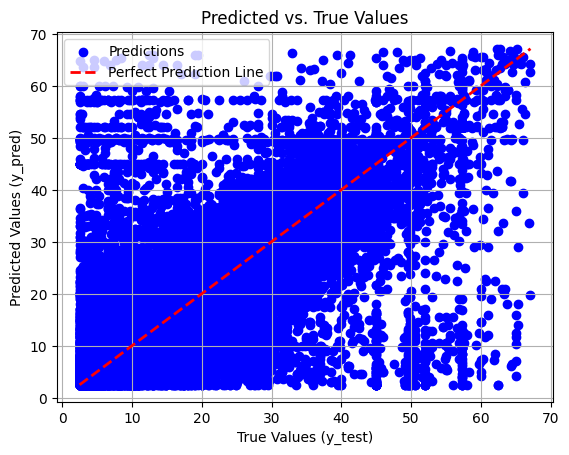

In [109]:
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')

# Add labels and title
plt.xlabel('True Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

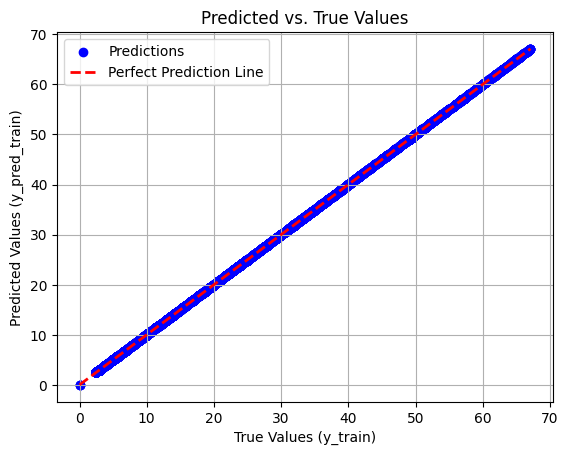

In [110]:
plt.scatter(y_train, y_pred_train, color='blue', label='Predictions')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction Line')

# Add labels and title
plt.xlabel('True Values (y_train)')
plt.ylabel('Predicted Values (y_pred_train)')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [111]:
# Define a scoring metric
scoring = make_scorer(mean_squared_error, greater_is_better=False)
kf = KFold(n_splits=5, shuffle= True, random_state=42)
# Use cross-validation to evaluate the model
scores = cross_val_score(model, X, y, cv=kf, scoring=scoring)

In [112]:
# Output the cross-validated scores
print(f"Cross-validated scores: {-scores}")
print(f"Mean accuracy: {np.mean(-scores):.3f}")
print(f"Standard deviation: {np.std(-scores):.3f}")

Cross-validated scores: [23.5089275  23.63601214 23.95290632 24.29446439 25.06363521]
Mean accuracy: 24.091
Standard deviation: 0.557


In [113]:
print("Parameters are ", model.get_params())

Parameters are  {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


In [114]:
parameters = {
    'min_samples_split': [1,2,5,10,15], 
    'min_samples_leaf':[1,2,5,10,15]
}
model = DecisionTreeRegressor()
# Set up the grid search
grid_search = GridSearchCV(estimator=model, param_grid=parameters, 
                           scoring='neg_mean_squared_error', 
                           cv=kf, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ............min_samples_leaf=1, min_samples_split=1; total time=   0.0s
[CV] END ............min_samples_leaf=1, min_samples_split=1; total time=   0.0s
[CV] END ............min_samples_leaf=1, min_samples_split=1; total time=   0.1s
[CV] END ............min_samples_leaf=1, min_samples_split=1; total time=   0.0s
[CV] END ............min_samples_leaf=1, min_samples_split=1; total time=   0.0s
[CV] END ............min_samples_leaf=1, min_samples_split=5; total time=   7.4s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=   8.1s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=   8.5s
[CV] END ............min_samples_leaf=1, min_samples_split=5; total time=   8.7s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=   9.3s
[CV] END ............min_samples_leaf=1, min_samples_split=2; total time=   9.0s
[CV] END ............min_samples_leaf=1, min_sa

/home/ziad/MachineLearning/Projects/Car-travels/enviro/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ziad/MachineLearning/Projects/Car-travels/enviro/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ziad/MachineLearning/Projects/Car-travels/enviro/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/ziad/MachineLearning/Projects/Car-travels/enviro

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 5, 10, 15],
                         'min_samples_split': [1, 2, 5, 10, 15]},
             scoring='neg_mean_squared_error', verbose=2)

In [115]:
# Retrieve the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)

# Evaluate the model
mse_decision = mean_squared_error(y_test, y_pred_grid)
print(f"Mean Squared Error of the best model: {mse_decision:.3f}")

r2_decision = r2_score(y_true=y_test, y_pred= y_pred_grid)
print(f"R squared of the best model: {r2_decision:.3f}")

y_pred_train_grid = best_model.predict(X_train)

Best hyperparameters: {'min_samples_leaf': 15, 'min_samples_split': 2}
Mean Squared Error of the best model: 13.381
R squared of the best model: 0.828


In [116]:
y_pred_train_grid = best_model.predict(X_train)
# Evaluate the model
mse = mean_squared_error(y_train, y_pred_train_grid)
print(f"Mean Squared Error of the best model: {mse:.3f}")
r2_ = r2_score(y_true=y_train, y_pred= y_pred_train_grid)
print(f"R squared of the best model: {r2_:.3f}")


Mean Squared Error of the best model: 9.525
R squared of the best model: 0.878


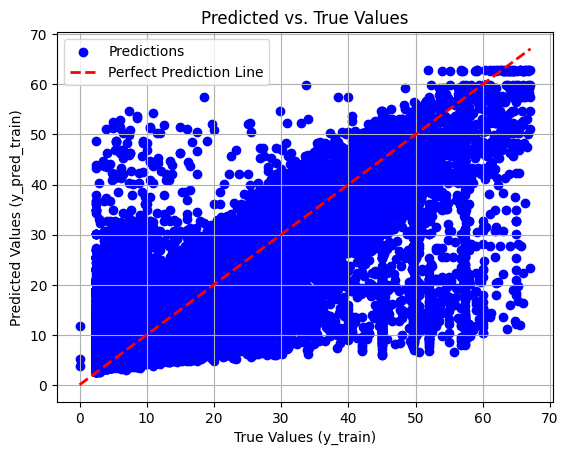

In [117]:
plt.scatter(y_train, y_pred_train_grid, color='blue', label='Predictions')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction Line')

# Add labels and title
plt.xlabel('True Values (y_train)')
plt.ylabel('Predicted Values (y_pred_train)')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [118]:
model_rand = RandomForestRegressor()
model_rand.fit(X_train, y_train)

RandomForestRegressor()

In [119]:
print("Hyperparameters of the trained model: ", model_rand.get_params())

Hyperparameters of the trained model:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [120]:
y_pred_rand = model_rand.predict(X_test)

# Evaluate the model
mse_rand = mean_squared_error(y_test, y_pred_rand)
print(f"Mean Squared Error of the random forest model: {mse_rand:.3f}")

r2_rand = r2_score(y_true=y_test, y_pred= y_pred_rand)
print(f"R squared of the random forest model: {r2_rand:.3f}")

Mean Squared Error of the random forest model: 12.142
R squared of the random forest model: 0.844


/home/ziad/MachineLearning/Projects/Car-travels/enviro/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


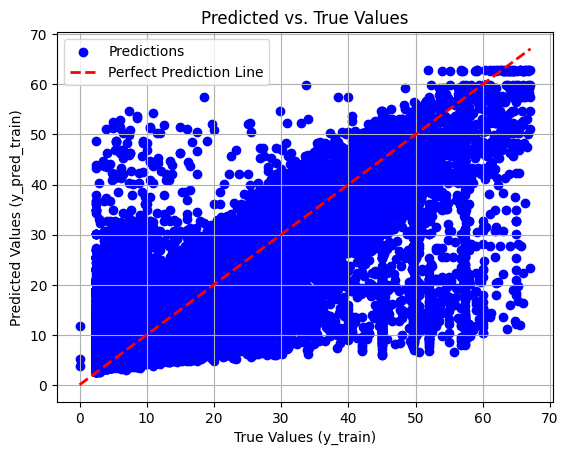

In [121]:
y_pred_train_rand = best_model.predict(X_train)
plt.scatter(y_train, y_pred_train_rand, color='blue', label='Predictions')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction Line')

# Add labels and title
plt.xlabel('True Values (y_train)')
plt.ylabel('Predicted Values (y_pred_train)')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [124]:
from sklearn.svm import SVR

In [125]:
svr_scaler= StandardScaler()
X_train_scaled = svr_scaler.fit_transform(X_train)
X_test_scaled = svr_scaler.fit(X_test)

In [126]:
svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train)

In [ ]:
y_pred_svr = svr.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"Mean Squared Error of the SVR model: {mse_svr:.3f}")

r2_svr = r2_score(y_true=y_test, y_pred= y_pred_svr)
print(f"R squared of the SVR model: {r2_svr:.3f}")

In [ ]:
hypar_svr = {
    'C' : [],
    'gamma':[],
    'epsilon': []
}

In [ ]:
random_svr = RandomizedSearchCV(
        svr,
        hypar_svr,
        scoring='neg_mean_squared_error', 
        cv=kf, n_jobs=-1, verbose=2
)

## Comparison

In [ ]:
from sklearn.ensemble import VotingRegressor as VR

In [122]:
classifiers = [
    ('Decision Tree', best_model),
    ('Random Forest', model_rand),
    ('SVR', svr)
]

NameError: name 'svr' is not defined